In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import string
import os
from sklearn.svm import SVC

# 1. Preprocessing

In [ ]:
def preprocess(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Adaptive threshold for screenshot text
    th = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        15, 10
    )

    # Denoising
    th = cv2.medianBlur(th, 3)
    return th

# 2. Text Segmentation

In [ ]:
def segment_lines(binary_img):
    # Sum each row to find text regions
    hist = np.sum(binary_img, axis=1)
    lines = []
    
    start = None
    for i, v in enumerate(hist):
        if v > 0 and start is None:
            start = i
        elif v == 0 and start is not None:
            end = i
            if end - start > 5:
                lines.append((start, end))
            start = None
    
    return lines

# 3. Word & Character Segmentation

In [ ]:
def segment_characters(line_img):
    # Connected component analysis
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(line_img)

    char_imgs = []
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        
        if w < 2 or h < 10:  
            continue  # ignore noise
        
        char_crop = line_img[y:y+h, x:x+w]
        char_imgs.append((x, char_crop))

    # Sort by X coordinate
    char_imgs.sort(key=lambda x: x[0])
    return [img for x, img in char_imgs]

# 4. Feature Extraction

In [ ]:
hog = cv2.HOGDescriptor(
    _winSize=(32, 32),
    _blockSize=(16, 16),
    _blockStride=(8, 8),
    _cellSize=(8, 8),
    _nbins=9
)

def extract_hog(img):
    # Resize each character to fixed size
    img = cv2.resize(img, (32, 32))
    return hog.compute(img).reshape(-1)


# 5. Classification

In [ ]:
def generate_training_data(font_files):
    X, y = [], []
    chars = string.ascii_letters + string.digits

    for font_path in font_files:
        for c in chars:
            img = Image.new("L", (64, 64), color=255)
            draw = ImageDraw.Draw(img)
            font = ImageFont.truetype(font_path, size=48)
            draw.text((8, 5), c, font=font, fill=0)

            img = np.array(img)
            img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

            X.append(extract_hog(img))
            y.append(c)

    return np.array(X), np.array(y)

In [ ]:
def train_svm(X, y):
    svm = SVC(kernel='linear', probability=False)
    svm.fit(X, y)
    return svm

# 6. OCR Inference

In [ ]:
def recognize_line(line_img, svm):
    chars = segment_characters(line_img)
    text = ""

    for cimg in chars:
        feat = extract_hog(cimg)
        pred = svm.predict([feat])[0]
        text += pred

    return text

# 7. Full OCR

In [ ]:
def ocr(img, svm):
    binary = preprocess(img)
    lines = segment_lines(binary)

    results = []
    for (start, end) in lines:
        line_img = binary[start:end, :]
        text = recognize_line(line_img, svm)
        results.append(text)

    return "\n".join(results)


---

# TEST Templates Generator

In [13]:
from PIL import Image, ImageDraw, ImageFont

font = ImageFont.truetype("../../input/fonts/Inter-Regular.ttf", size=48)

chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
templates = {}

for c in chars:
    img = Image.new("L", (80, 80), color=255) # white bg
    draw = ImageDraw.Draw(img)
    draw.text((10, 10), c, font=font, fill=0)
    
    # Convert PIL → numpy + resize for matching
    tmpl = np.array(img, dtype=np.uint8)
    tmpl = cv2.resize(tmpl, (32, 32))  # match segmentation size
    
    templates[c] = np.array(img, dtype=np.uint8)

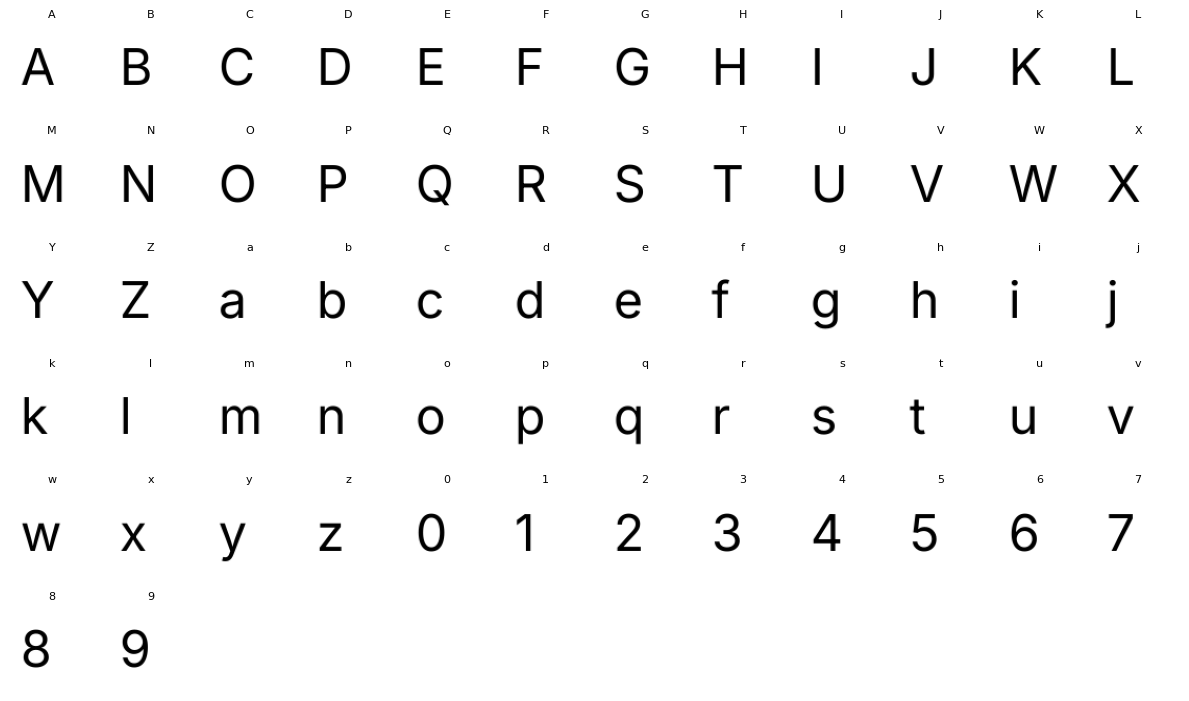

In [14]:
# Create a grid preview
cols = 12
rows = (len(chars) + cols - 1) // cols
fig = plt.figure(figsize=(12, rows * 1.2))

for i, c in enumerate(chars):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.imshow(templates[c], cmap="gray")
    ax.set_title(c, fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

# TEST

In [17]:
# preprocess
img = cv2.imread("../../input/bni-receipts/genuine/g_005.png", 0)

if img is None:
    raise Exception('Image is not found!')

_, th = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# segment
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(th)

chars = []
for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    if area < 20: continue
    
    char_img = th[y:y+h, x:x+w]
    char_img = cv2.resize(char_img, (32, 32))
    chars.append((x, char_img))

# load templates
# templates = {}

# characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

# for char in characters:
#     path = f"templates/{char}.png"
#     image = cv2.imread(path, 0)          # read as grayscale
    
#     if image is None:
#         print('image is none')
#         continue
    
#     resized = cv2.resize(image, (32, 32)) # resize to 32x32
#     templates[char] = resized

# recognize
result = ""
for x, char_img in sorted(chars, key=lambda item: item[0]):
    best_char = None
    best_score = -1
    for c, tmpl in templates.items():
        score = cv2.matchTemplate(char_img, tmpl, cv2.TM_CCOEFF_NORMED)[0][0]
        if score > best_score:
            best_score = score
            best_char = c
        
    if best_char is None:
        best_char = ""
    
    result += best_char

print('Hasil: ')
print(result)


Hasil: 
oJJJ44yJJy4J4JJy4JyJyy4J44JJJ4JJyJJ444JJyJJJ4JJJJJJ4JJyJJJJJyyJJJ4y4JJ4yJJJJJJJJJJJJJJJJJJJJJJ


# TEST 2

In [ ]:
import cv2
import numpy as np
from typing import List, Tuple, Dict
from numpy.typing import NDArray


# 1) Preprocess
def preprocess(img: NDArray[np.uint8]) -> NDArray[np.uint8]:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binar = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        21, 10
    )
    return binar


# 2) Line segmentation
def segment_lines(bin_img: NDArray[np.uint8]) -> List[Tuple[int, int]]:
    hist = np.sum(bin_img, axis=1)
    lines: List[Tuple[int, int]] = []
    start: int | None = None

    for i, v in enumerate(hist):
        if v > 0 and start is None:
            start = i
        elif v == 0 and start is not None:
            lines.append((start, i))
            start = None

    return lines


# 3) Character segmentation
def segment_chars(line_img: NDArray[np.uint8]) -> List[NDArray[np.uint8]]:
    vproj = np.sum(line_img, axis=0)
    chars: List[NDArray[np.uint8]] = []
    start: int | None = None

    for x, v in enumerate(vproj):
        if v > 0 and start is None:
            start = x
        elif v == 0 and start is not None:
            chars.append(line_img[:, start:x])
            start = None

    return chars


# 4) Normalize
def normalize(img: NDArray[np.uint8]) -> NDArray[np.uint8]:
    return cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)


# 5) Zoning feature extraction
def zoning(img: NDArray[np.uint8]) -> NDArray[np.float64]:
    img = img // 255
    zones: List[float] = []

    h, w = img.shape
    h8, w8 = h // 4, w // 4

    for i in range(4):
        for j in range(4):
            zone = img[i*h8:(i+1)*h8, j*w8:(j+1)*w8]
            zones.append(float(np.mean(zone)))

    return np.array(zones, dtype=np.float64)


# 6) Nearest prototype classifier
def classify_char(
    feat: NDArray[np.float64],
    prototypes: Dict[str, NDArray[np.float64]]
) -> str:
    best: str | None = None
    best_dist: float = 1e9

    for char, f in prototypes.items():
        d = float(np.linalg.norm(feat - f))
        if d < best_dist:
            best_dist = d
            best = char
    return best if best is not None else "?"


# 7) OCR pipeline
def classical_ocr(img: NDArray[np.uint8] | np.ndarray) -> str:
    bin_img = preprocess(img)
    line_ranges = segment_lines(bin_img)

    # Extract prototypes using the first line
    prototypes: Dict[str, NDArray[np.float64]] = {}
    first_line = bin_img[line_ranges[0][0]:line_ranges[0][1], :]
    chars = segment_chars(first_line)

    alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
    for ch_img, ch in zip(chars, alphabet[:len(chars)]):
        f = zoning(normalize(ch_img))
        prototypes[ch] = f

    # OCR full text
    results: List[str] = []
    for (y1, y2) in line_ranges:
        line_img = bin_img[y1:y2, :]
        char_imgs = segment_chars(line_img)

        line_text = ""
        for ch_img in char_imgs:
            feat = zoning(normalize(ch_img))
            line_text += classify_char(feat, prototypes)

        results.append(line_text)

    return "\n".join(results)


In [20]:
img = cv2.imread('../../input/bni-receipts/genuine/g_001.png')

if img is None:
    raise Exception('Image is not found!')

result = classical_ocr(img)

print(result)

ABCD
CDACCC
DAAAAADABAACADADBAAAD
ADAAAAAA
AAAAAAAAAAAAAAAAAACCA
DAACAAAAAAAAAAAAAAAAAAAA
DCBCDCBB
C
AAAADCDBACAADACAAD
CAABA
CBBBCDCABB
C
ACAAACAAAACB
AAAAAAAAAA
AAAAAADAAAAADAB
C
AAAAAACAAAAAAAA
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
AAAADDAAAAAA
CCABCCBCDDBABA
C
CADABBBACAAAAAAAA
CADABABAAAAAABAAAAAAAAAAAAAA
CC
C
ADAABACCAAAAAAAA
CCCCC
CC
AAAAAAAAAAAAAAAAAAAAC
CC
CCABCCABBABAC
C
AAAAAAADABAABAAAAAAAAAAAABAA
BAABCAAAADDABDDBC
AAAAAAAAAAAAAACA
ACADDAAAACAAAAABAA


## 2

In [1]:
from math import ceil
from sklearn.cluster import KMeans


def preprocess(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binar = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        21, 10
    )
    # noise removal
    binar = cv2.medianBlur(binar, 3)
    return binar


def segment_lines(bin_img):
    hist = np.sum(bin_img, axis=1)
    lines = []
    start = None

    for i, v in enumerate(hist):
        if v > 0 and start is None:
            start = i
        elif v == 0 and start is not None:
            lines.append((start, i))
            start = None

    return lines

def segment_chars(line_img):
    vproj = np.sum(line_img, axis=0)
    chars = []
    start = None

    for x, v in enumerate(vproj):
        if v > 0 and start is None:
            start = x
        elif v == 0 and start is not None:
            if x - start > 2:
                chars.append(line_img[:, start:x])
            start = None

    return chars


def normalize(ch):
    return cv2.resize(ch, (32, 32), interpolation=cv2.INTER_AREA)


def extract_features(img):
    img = img // 255
    
    # zoning 4x4
    h, w = img.shape
    h4, w4 = h // 4, w // 4
    zones = []
    
    for i in range(4):
        for j in range(4):
            zone = img[i*h4:(i+1)*h4, j*w4:(j+1)*w4]
            zones.append(np.mean(zone))

    # projection histograms
    hproj = np.sum(img, axis=1) / w
    vproj = np.sum(img, axis=0) / h

    # combine
    return np.concatenate([zones, hproj, vproj])


def extract_all_characters(bin_img):
    features = []
    char_images = []
    positions = []

    line_ranges = segment_lines(bin_img)

    for li, (y1, y2) in enumerate(line_ranges):
        line_img = bin_img[y1:y2, :]
        chars = segment_chars(line_img)

        x_cursor = 0
        for ch in chars:
            norm = normalize(ch)
            feat = extract_features(norm)

            features.append(feat)
            char_images.append(norm)     # <-- store image here
            positions.append((li, x_cursor))

            x_cursor += 1

    return np.array(features), char_images, positions, line_ranges


def cluster_characters(features, n_clusters=40):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(features)
    return labels, kmeans


def assign_labels_to_clusters(labels, char_images):
    cluster_to_char = {}

    print("=== Cluster Labeling ===")
    unique_clusters = np.unique(labels)

    for cluster_id in unique_clusters:
        # Show grid of example characters
        show_cluster_images(cluster_id, labels, char_images)

        # Ask user for label
        text = input(f"Label for cluster {cluster_id} (type a character, or Enter to skip): ")

        if text.strip() == "":
            cluster_to_char[cluster_id] = "?"  # unknown
        else:
            cluster_to_char[cluster_id] = text.strip()[0]  # use first character

    return cluster_to_char


def show_cluster_images(cluster_id, labels, char_images, max_samples=12):
    # Get indices of this cluster
    idx = np.where(labels == cluster_id)[0]

    if len(idx) == 0:
        return None

    # Choose up to max_samples examples
    samples = idx[:max_samples]
    imgs = [char_images[i] for i in samples]

    # Grid setup
    cols = 6
    rows = ceil(len(imgs) / cols)

    plt.figure(figsize=(10, 2 * rows))
    plt.suptitle(f"Cluster {cluster_id} — {len(idx)} samples", fontsize=16)

    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.show()


def build_text_output(labels, positions, cluster_to_char, line_ranges):
    # Build map: for each line, a list of characters in order
    lines = {i: [] for i in range(len(line_ranges))}

    for (line_idx, x_pos), lbl in zip(positions, labels):
        lines[line_idx].append((x_pos, cluster_to_char[lbl]))

    # assemble lines
    out = []
    for i in range(len(line_ranges)):
        line = "".join(ch for _, ch in sorted(lines[i], key=lambda a: a[0]))
        out.append(line)

    return "\n".join(out)


=== Cluster Labeling ===


c:\Users\KarlSchmidt\.conda\envs\gideon\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


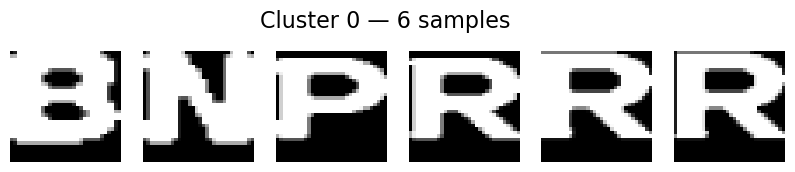

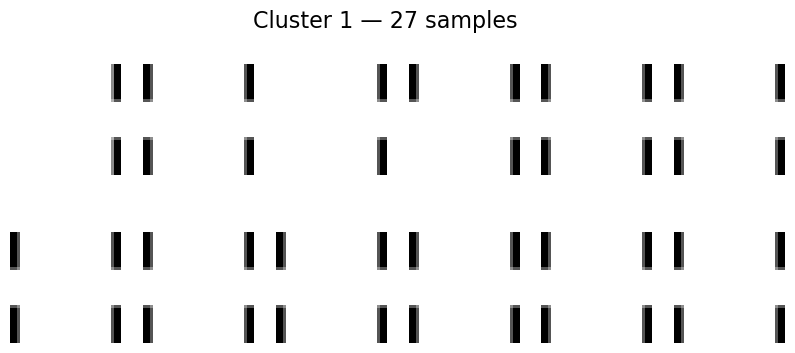

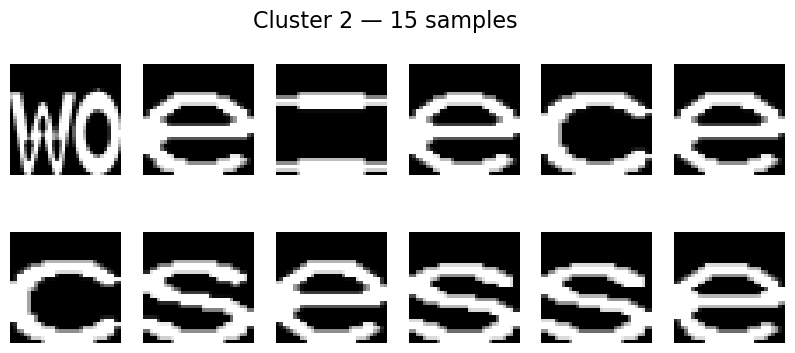

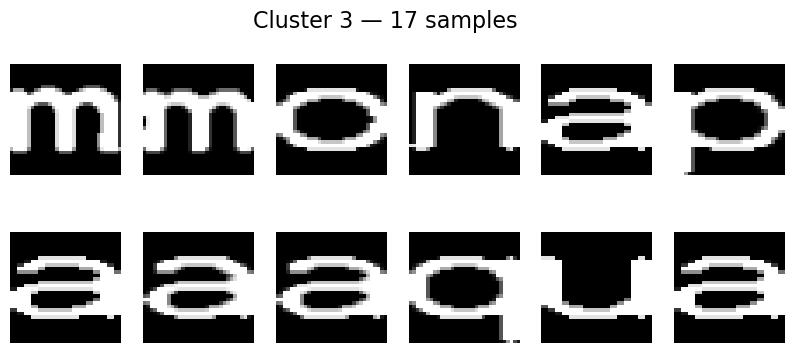

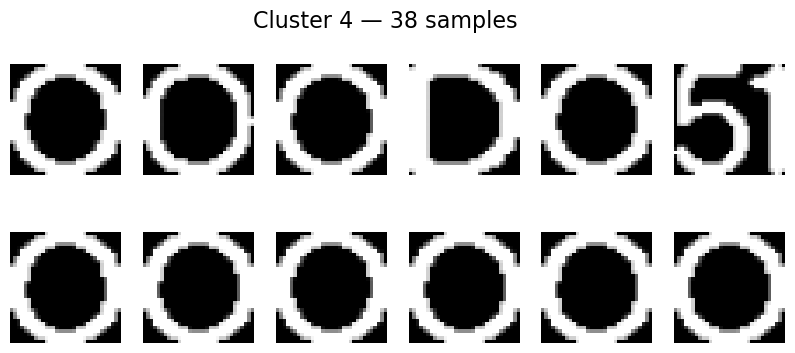

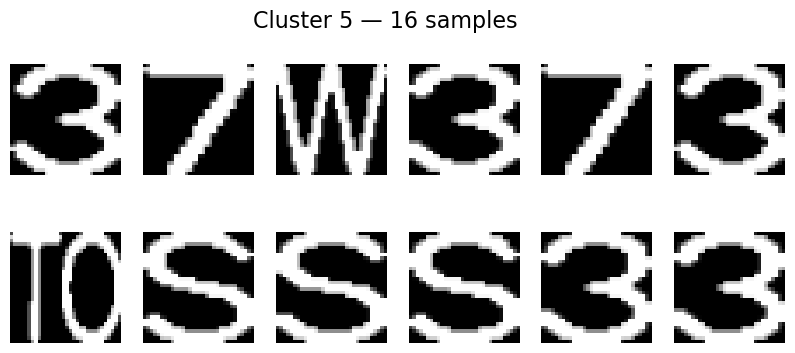

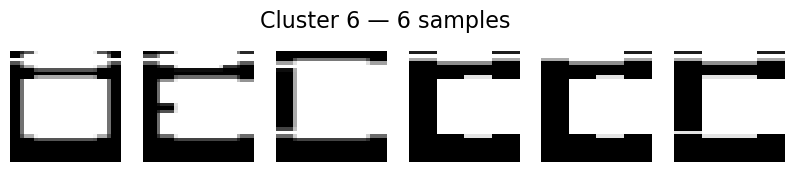

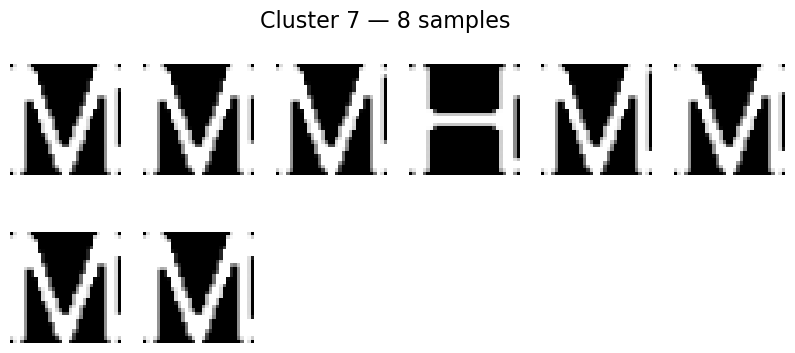

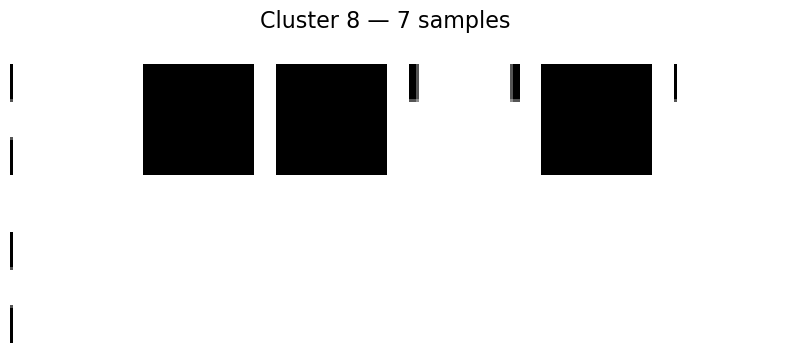

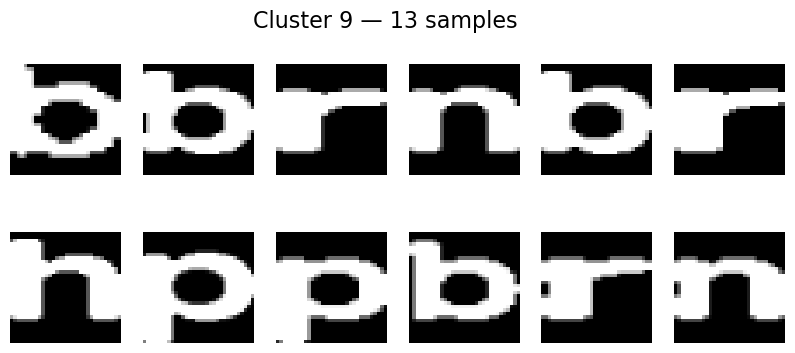

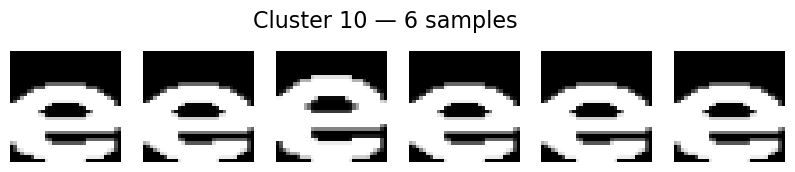

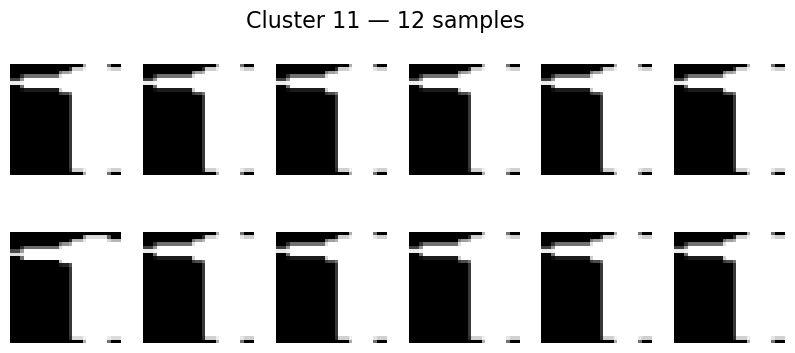

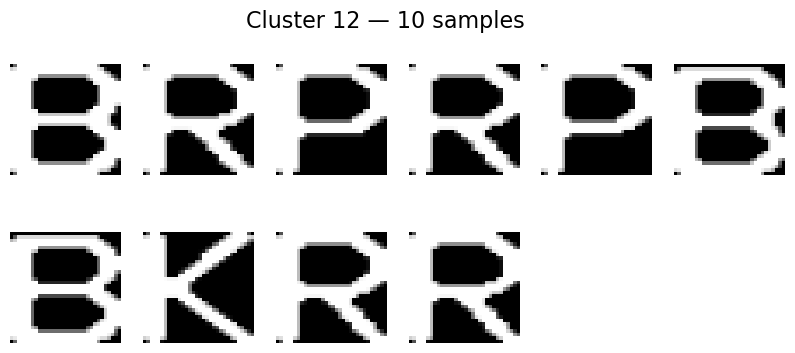

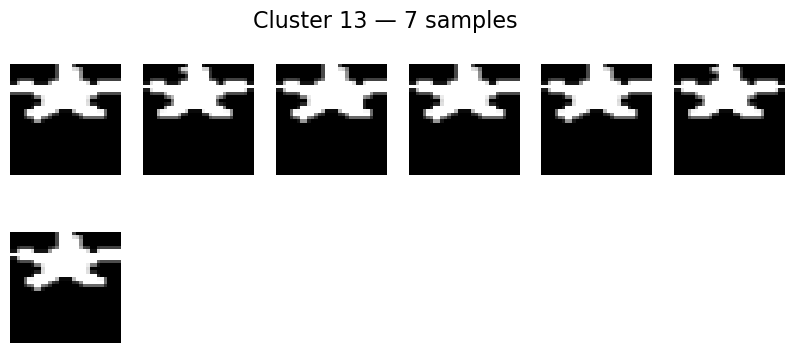

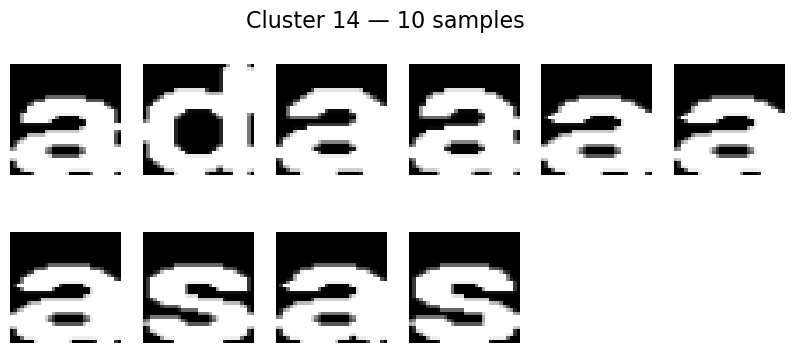

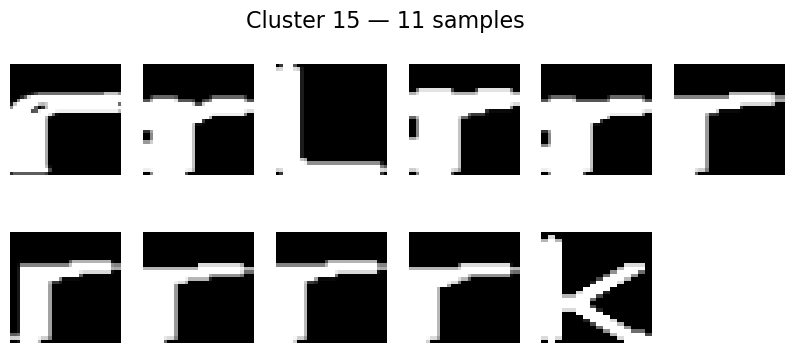

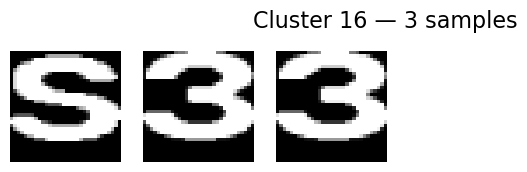

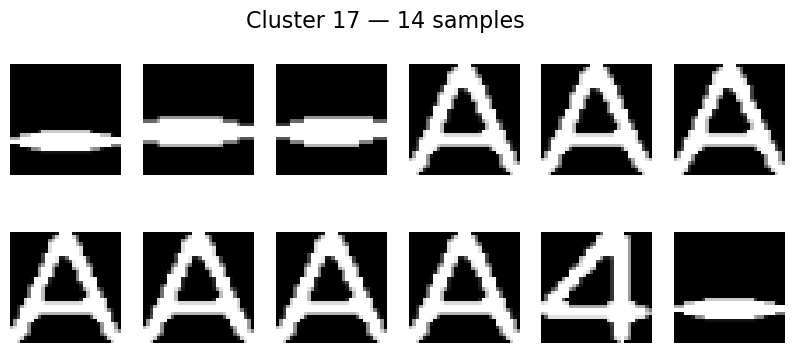

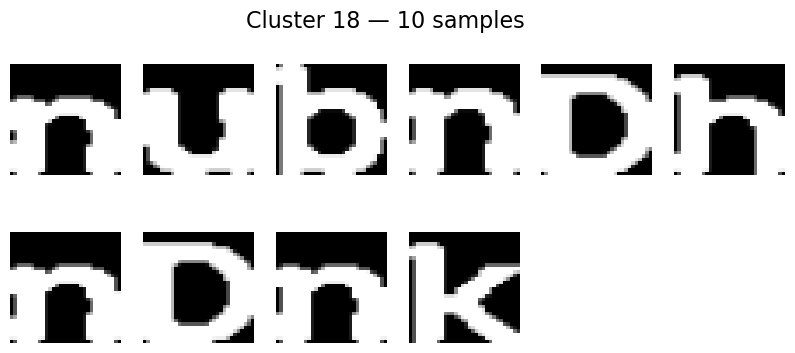

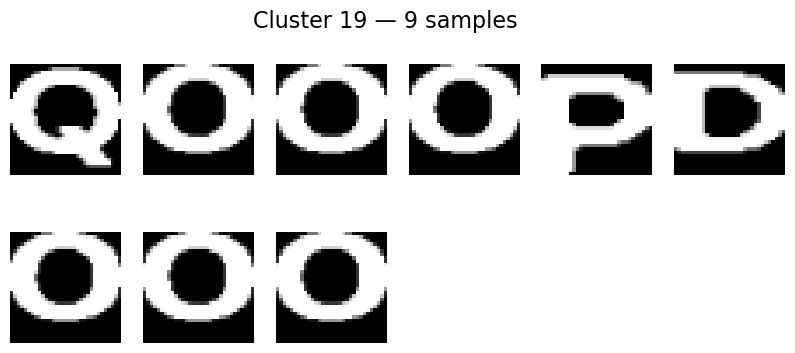

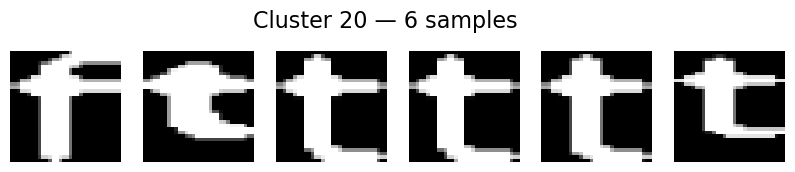

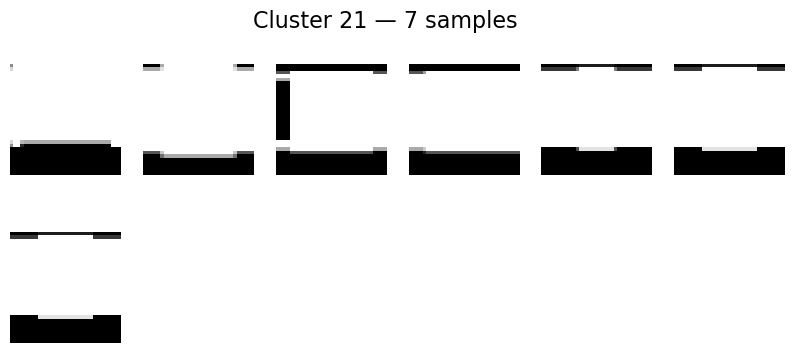

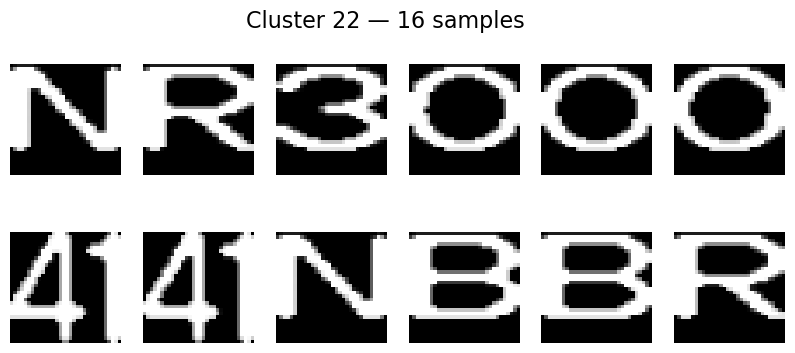

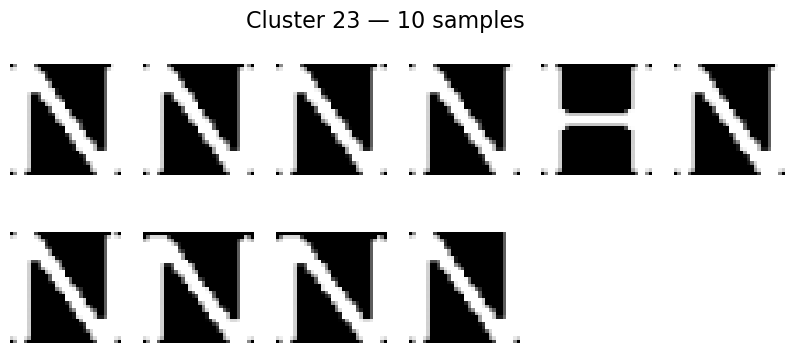

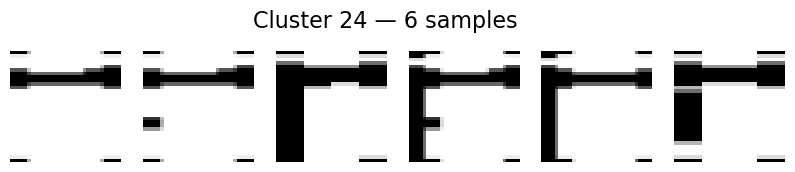

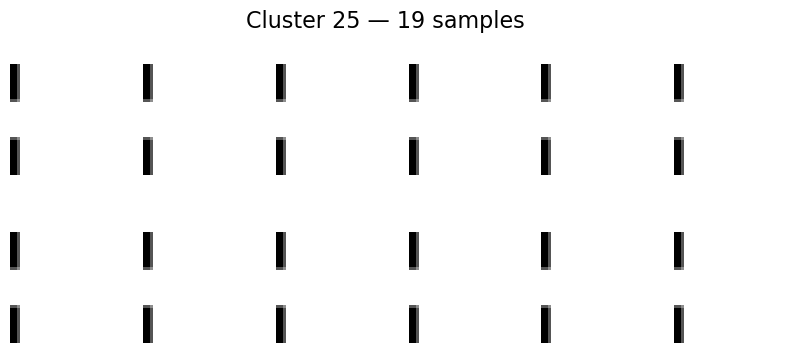

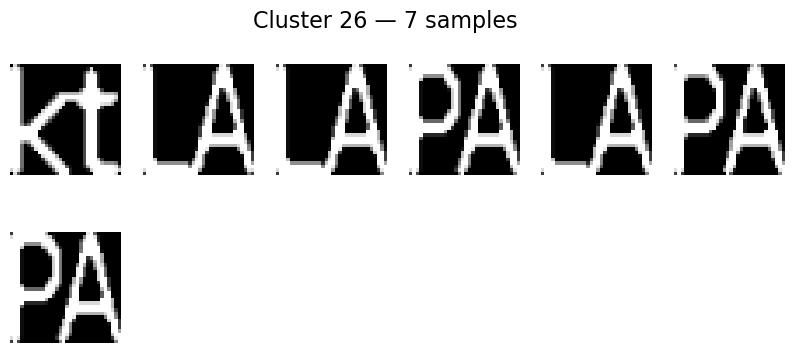

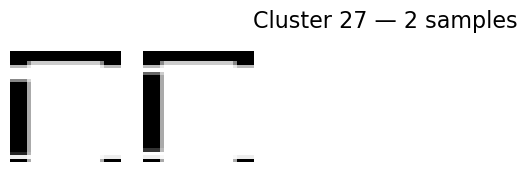

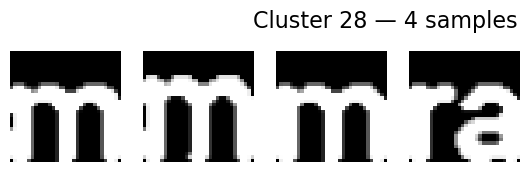

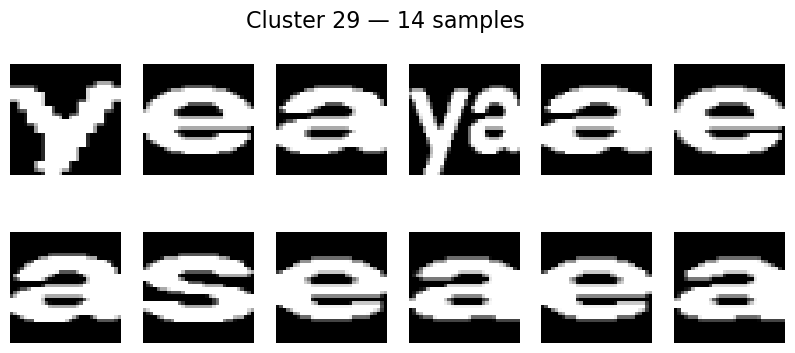

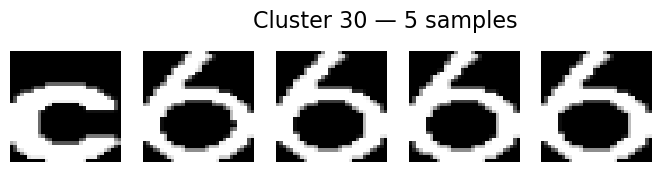

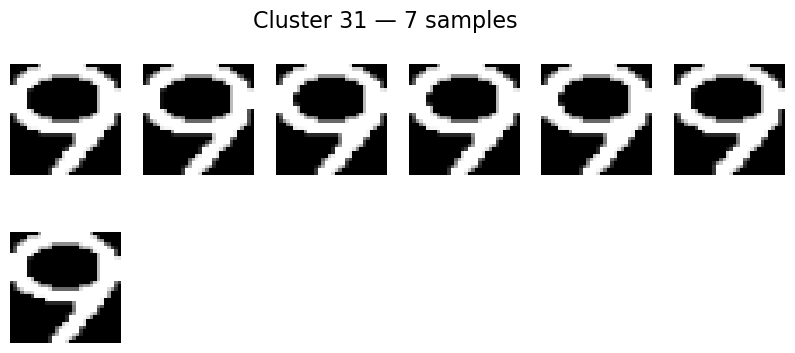

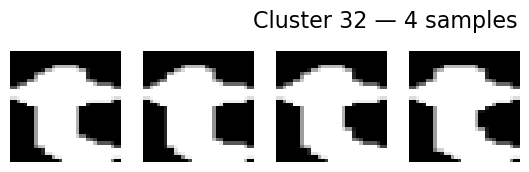

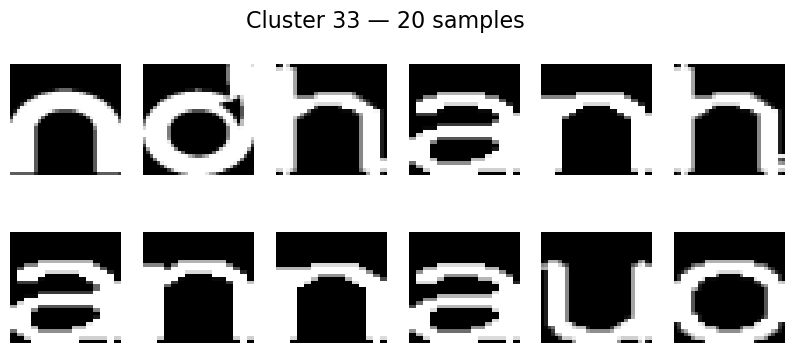

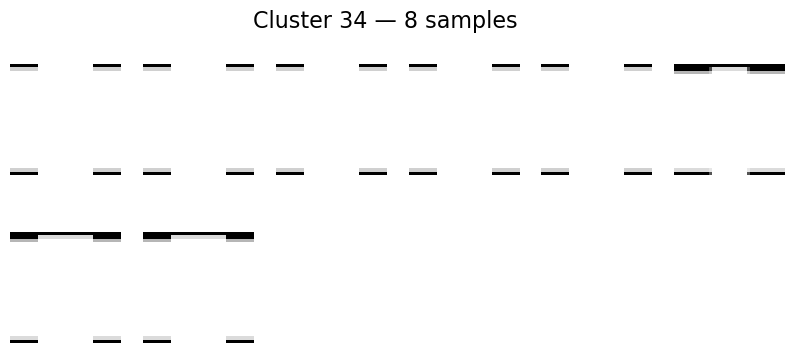

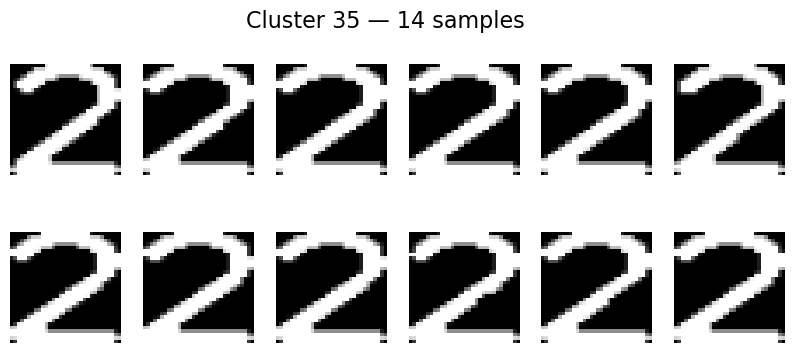

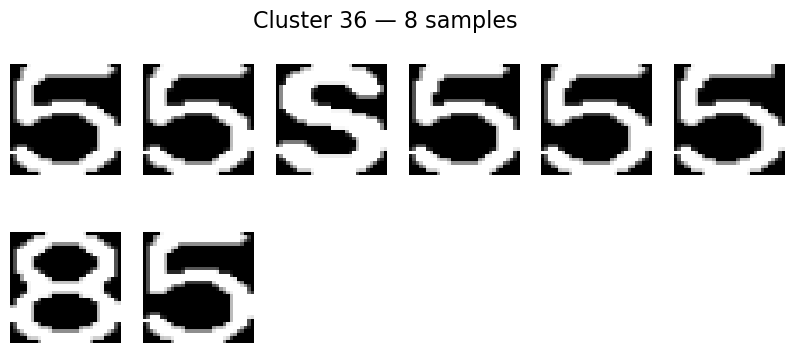

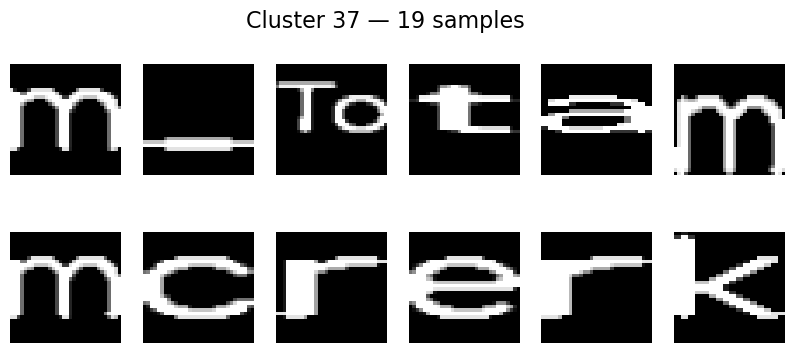

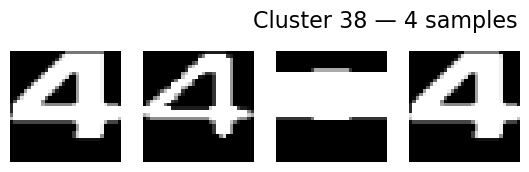

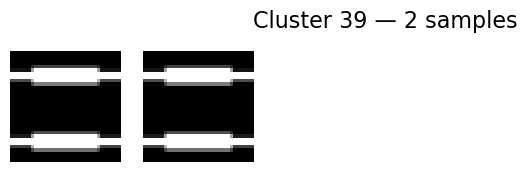


OCR RESULT:

?tta
t?m??t
?me?mm?m?n?tr?m??mm3t
??r?3nnn
oaa??a?23?64??4?ooh13
1?oha??a?aaoaao??o2aaa?6?
nbAbaN?*
M
????1a1?3?3o1oho3a
?3??a
2A?Aba**A*
M
?a?3??3a?3oh?
RRRRRRR6?3
nmom33?me?mm?m?
M
?e53eet?e??5???
?RRRR?R?R?R?R?R?RRM??RRMR?R?R?R?R?R??RRRR?R?R?RR
555???r?3nnn
Ab9*N??baeA*A9
M
??a?tttoha??2?2oa
??a?ttto??6oeaaaa?aa??a2oa?
3a5Ntthha3a?
?e5ee5ee3555?ee5??t
Ab9*N?9?A**A*N
M
at?ot5?a??6oeaaaa6??aa?2?e2o
?t5tN??t?a1tta1?h
?e5o5ee5e553??t?
1tt?11??6atao??ae??


In [3]:
img = cv2.imread("../../input/bni-receipts/genuine/g_001.png")
bin_img = preprocess(img)

features, char_images, positions, line_ranges = extract_all_characters(bin_img)

labels, kmeans = cluster_characters(features, n_clusters=40)

cluster_to_char = assign_labels_to_clusters(labels, char_images)

result = build_text_output(labels, positions, cluster_to_char, line_ranges)

print("\nOCR RESULT:\n")
print(result)